In [22]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
DATASET = "../input/gis-dataset"

LABELS = os.listdir(DATASET)
print(LABELS)

['VegetationCrop', 'UnSuitablefarmLand', 'PermanentCrop', 'HighYieldCropsLand', 'ForestLand', 'HerbaceousVegetationLand']


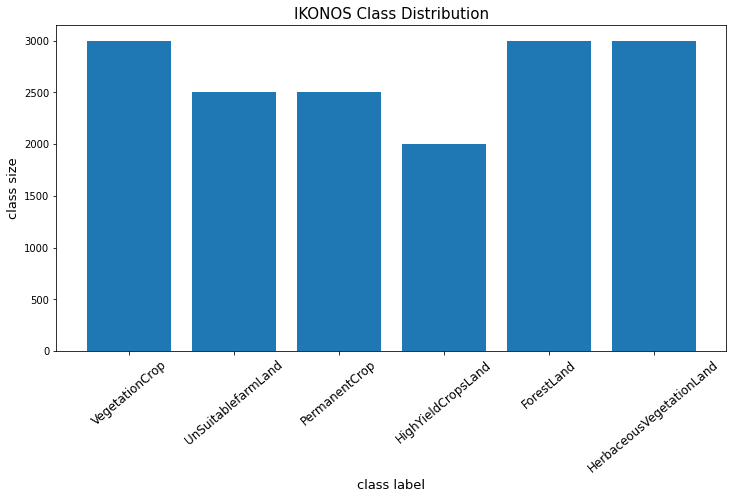

In [24]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('IKONOS Class Distribution', fontsize=15);

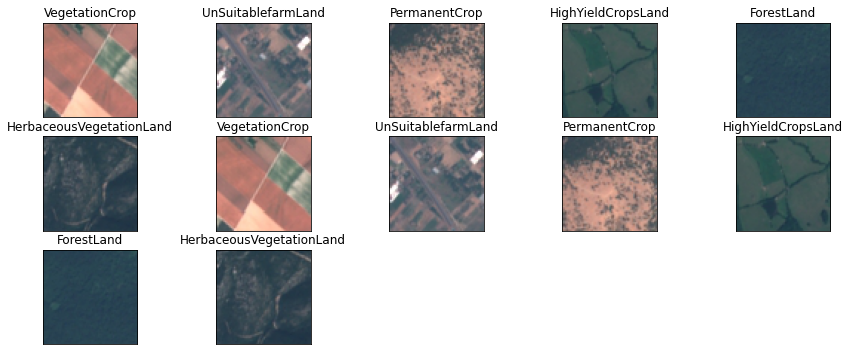

In [25]:
img_paths = [os.path.join(DATASET, ) for l in LABELS]
# print(FLABELS)
img_paths = [os.path.join(DATASET, l, l+'1000.jpg') for l in LABELS]
# print(img_paths)
len(img_paths)
img_paths = img_paths + [os.path.join(DATASET, l, l+'1000.jpg') for l in LABELS]

len(img_paths)
def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(12):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [26]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [27]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\.\.\/input\/gis-dataset', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\.\/input\/gis-dataset', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

100%|██████████| 3200/3200 [00:00<00:00, 260728.33it/s]

moving training files..
moving testing files..


In [28]:

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 12800 images belonging to 6 classes.
Found 3200 images belonging to 6 classes.


In [29]:
print(train_generator.class_indices)

{'ForestLand': 0, 'HerbaceousVegetationLand': 1, 'HighYieldCropsLand': 2, 'PermanentCrop': 3, 'UnSuitablefarmLand': 4, 'VegetationCrop': 5}


In [30]:
np.save('class_indices', train_generator.class_indices)

In [31]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 12800 images belonging to 6 classes.
Found 3200 images belonging to 6 classes.


In [32]:
train = rf_train_generator.next()
X_train = train[0].reshape(12800, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(3200, 12288)
y_test = test[1]

In [33]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=12800, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [34]:
# import random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.66


In [35]:
# INCEPTION NN & CNN
import keras
import keras.backend as K
from keras.layers import concatenate, Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, BatchNormalization
from keras.models import Model
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd

def inception_cnn(input_length, output_length, epochs=200, batch_size=256):
    loops = 35
    input_num = input_length // 5
    output_num = output_length // 5
    (x_train, y_train), (x_validation, y_validation), (x_test, y_test) = format_io.get_data(input_length, output_length)

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        y_train = y_train.reshape(y_train.shape[0], -1)
        x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1], x_validation.shape[2])
        y_validation = y_validation.reshape(y_validation.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
        y_test = y_test.reshape(y_test.shape[0], -1)
        input_shape = (1, loops, input_num)
    else:
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
        y_train = y_train.reshape(y_train.shape[0], -1)
        x_validation = x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)
        y_validation = y_validation.reshape(y_validation.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
        y_test = y_test.reshape(y_test.shape[0], -1)
        input_shape = (loops, input_num, 1)

    inp = Input(input_shape, name = 'input')
    bn = BatchNormalization(name = 'bn1')(inp)
    branch3x3x3x3 = Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = (1, 1), name = '1brach1_1')(bn)
    branch3x3x3x3 = Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = (1, 1), name = '1branch1_2')(branch3x3x3x3)
    branch3x3 = Conv2D(96, kernel_size = (3, 3), activation = 'relu', padding = 'same', strides = (1, 1), name = '1branch2')(bn)
    branch1x1 = Conv2D(64, kernel_size = (1, 1), activation = 'relu', padding = 'same', strides = (1, 1), name = '1branch3')(bn)
    branchpool = AveragePooling2D(pool_size = (3, 3), padding = 'same', strides = (1, 1), name = '1branch4_1')(bn)
    branchpool = Conv2D(32, kernel_size = (1, 1), activation = 'relu', padding = 'same', strides = (1, 1), name = '1branch4_2')(branchpool)
    x = concatenate([branch3x3x3x3, branch3x3, branch1x1, branchpool], name = 'concatenate1')
    branch1x3x3x1x1x3x3x1 = Conv2D(128, kernel_size = (1, 3), activation = 'relu', padding = 'valid', strides = (1, 1), name = '2brach1_1')(x)
    branch1x3x3x1x1x3x3x1 = Conv2D(128, kernel_size = (3, 1), activation = 'relu', padding = 'valid', strides = (1, 1), name = '2brach1_2')(branch1x3x3x1x1x3x3x1)
    branch1x3x3x1x1x3x3x1 = Conv2D(128, kernel_size = (1, 3), activation = 'relu', padding = 'same', strides = (2, 1), name = '2brach1_3')(branch1x3x3x1x1x3x3x1)
    branch1x3x3x1x1x3x3x1 = Conv2D(128, kernel_size = (3, 1), activation = 'relu', padding = 'same', strides = (1, 1), name = '2brach1_4')(branch1x3x3x1x1x3x3x1)
    branch1x3x3x1 = Conv2D(192, kernel_size = (1, 3), activation = 'relu', padding = 'valid', strides = (1, 1), name = '2branch2_1')(x)
    branch1x3x3x1 = Conv2D(192, kernel_size = (3, 1), activation = 'relu', padding = 'valid', strides = (2, 1), name = '2branch2_2')(branch1x3x3x1)
    branchpool = AveragePooling2D(pool_size = (2, 2), padding = 'same', strides = (1, 1), name = '2branch3_1')(x)
    branchpool = Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'valid', strides = (2, 1), name = '2branch3_2')(branchpool)
    x = concatenate([branch1x3x3x1x1x3x3x1, branch1x3x3x1, branchpool], name = 'concatenate2')  # 第二层
    x = MaxPool2D(pool_size = (2, 2), padding = 'same', name = 'maxpool1')(x)
    x = Flatten(name = 'flatten')(x)
    x = Dense(1024, activation = 'relu', name = 'fc1')(x)
    x = Dense(512, activation = 'relu', name = 'fc2')(x)
    x = Dense(y_train.shape[1], name = 'output')(x)
    model = Model(input = inp, output = x)

    model.compile(loss = keras.losses.mean_absolute_error, optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.mean_absolute_percentage_error])
    lrreduce = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 0, patience = 6, verbose = 0)
    earlystop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 15, verbose = 0)
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 0, validation_data = (x_validation, y_validation), callbacks = [lrreduce, earlystop])
    model.save('inception-cnn.h5')

In [36]:
# Creating mini batches of training data as training on whole data is difficult
ids_2 = np.random.choice(len(X_train), size=2160, replace=False)
X_train_mini_2 = X_train[ids_2]
y_train_mini_2 = rf_train_generator.classes[ids_2]

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_mini_2, y_train_mini_2)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial')

In [38]:
# Deep classification
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [40]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [41]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [42]:
# RESNET 50
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_____________________________

In [43]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [44]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=5,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
200/200 [==============================] - 28s 110ms/step - loss: 4.2683 - categorical_accuracy: 0.1813 - val_loss: 1.7930 - val_categorical_accuracy: 0.1875

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18750, saving model to ../working/model.weights.best.hdf5
Epoch 2/5
200/200 [==============================] - 22s 110ms/step - loss: 1.7852 - categorical_accuracy: 0.1946 - val_loss: 1.7820 - val_categorical_accuracy: 0.1875

Epoch 00002: val_categorical_accuracy did not improve from 0.18750
Epoch 3/5
200/200 [==============================] - 22s 108ms/step - loss: 1.7839 - categorical_accuracy: 0.1835 - val_loss: 1.7819 - val_categorical_accuracy: 0.1875

Epoch 00003: val_categorical_accuracy did not improve from 0.18750
Epoch 4/5
200/200 [==============================] - 21s 106ms/step - loss: 1.7826 - categorical_accuracy: 0.1920 - val_loss: 1.7818 - val_categorical_accuracy: 0.1875

Epoch 00004: val_categorical_accuracy did not improve from 0.18750
Epo

In [45]:
# re-train whole network with incepCNN 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=3,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/3
200/200 [==============================] - 31s 128ms/step - loss: 0.7581 - categorical_accuracy: 0.7626 - val_loss: 13.2617 - val_categorical_accuracy: 0.1875

Epoch 00001: val_categorical_accuracy did not improve from 0.18750
Epoch 2/3
200/200 [==============================] - 25s 122ms/step - loss: 0.2362 - categorical_accuracy: 0.9252 - val_loss: 19.8637 - val_categorical_accuracy: 0.1878

Epoch 00002: val_categorical_accuracy improved from 0.18750 to 0.18781, saving model to ../working/model.weights.best.hdf5
Epoch 3/3
200/200 [==============================] - 25s 123ms/step - loss: 0.1746 - categorical_accuracy: 0.9418 - val_loss: 9.2137 - val_categorical_accuracy: 0.1994

Epoch 00003: val_categorical_accuracy improved from 0.18781 to 0.19938, saving model to ../working/model.weights.best.hdf5


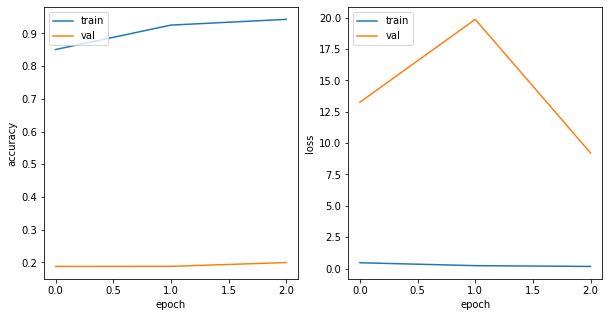

In [46]:
plot_history(resnet50_history)

In [47]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 3200 images belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.19875
Global F2 Score: 0.19875


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
ForestLand,0.00000,0.00,0.000000,600.0
HerbaceousVegetationLand,0.19084,1.00,0.320513,600.0
HighYieldCropsLand,0.00000,0.00,0.000000,400.0
PermanentCrop,0.00000,0.00,0.000000,500.0
UnSuitablefarmLand,0.00000,0.00,0.000000,500.0
VegetationCrop,0.75000,0.06,0.111111,600.0


In [48]:
# Save the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5')

In [49]:
# ResNet50V2 Model

resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________

In [50]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 10

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [51]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=5,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
200/200 [==============================] - 25s 109ms/step - loss: 5.5045 - categorical_accuracy: 0.6205 - val_loss: 0.7140 - val_categorical_accuracy: 0.7922

Epoch 00001: val_categorical_accuracy improved from -inf to 0.79219, saving model to ../working/model.weights.best.hdf5
Epoch 2/5
200/200 [==============================] - 21s 107ms/step - loss: 0.8888 - categorical_accuracy: 0.7372 - val_loss: 0.9241 - val_categorical_accuracy: 0.7766

Epoch 00002: val_categorical_accuracy did not improve from 0.79219
Epoch 3/5
200/200 [==============================] - 21s 106ms/step - loss: 0.8743 - categorical_accuracy: 0.7437 - val_loss: 1.0373 - val_categorical_accuracy: 0.8062

Epoch 00003: val_categorical_accuracy improved from 0.79219 to 0.80625, saving model to ../working/model.weights.best.hdf5
Epoch 4/5
200/200 [==============================] - 21s 104ms/step - loss: 0.8178 - categorical_accuracy: 0.7585 - val_loss: 0.6202 - val_categorical_accuracy: 0.8053

Epoch 00004: v

In [52]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10
200/200 [==============================] - 30s 126ms/step - loss: 2.3546 - categorical_accuracy: 0.5667 - val_loss: 0.7485 - val_categorical_accuracy: 0.7509

Epoch 00001: val_categorical_accuracy did not improve from 0.81531
Epoch 2/10
200/200 [==============================] - 24s 121ms/step - loss: 0.6519 - categorical_accuracy: 0.7875 - val_loss: 0.5146 - val_categorical_accuracy: 0.8388

Epoch 00002: val_categorical_accuracy improved from 0.81531 to 0.83875, saving model to ../working/model.weights.best.hdf5
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 0.4920 - categorical_accuracy: 0.8444 - val_loss: 0.3148 - val_categorical_accuracy: 0.9016

Epoch 00003: val_categorical_accuracy improved from 0.83875 to 0.90156, saving model to ../working/model.weights.best.hdf5
Epoch 4/10
200/200 [==============================] - 24s 120ms/step - loss: 0.4075 - categorical_accuracy: 0.8715 - val_loss: 0.2742 - val_categorical_accuracy: 0.9106

Epoch 0

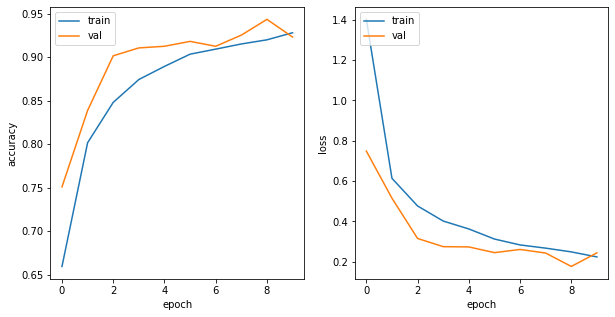

In [53]:
plot_history(resnet50V2_history)

In [54]:
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 3200 images belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9371875
Global F2 Score: 0.9371875


,Precision,Recall,F-Score,Support
ForestLand,0.907436,0.996667,0.949960,600.0
HerbaceousVegetationLand,0.947461,0.901667,0.923997,600.0
HighYieldCropsLand,0.951531,0.932500,0.941919,400.0
PermanentCrop,0.893910,0.910000,0.901883,500.0
UnSuitablefarmLand,0.959514,0.948000,0.953722,500.0
VegetationCrop,0.970435,0.930000,0.949787,600.0


In [55]:
# Save the model and the weights
resnet50V2_model.save('../working/ResNet50V2_eurosat.h5')

In [56]:
# ResNet152V2 Model

resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet152V2_model.summary()

234553344/234545216 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________

In [57]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 10

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [58]:
# First Pretraining the dense layer
resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
200/200 [==============================] - 34s 132ms/step - loss: 2.5766 - categorical_accuracy: 0.6287 - val_loss: 0.8284 - val_categorical_accuracy: 0.7844

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78438, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
200/200 [==============================] - 25s 124ms/step - loss: 1.0643 - categorical_accuracy: 0.7291 - val_loss: 0.8368 - val_categorical_accuracy: 0.7909

Epoch 00002: val_categorical_accuracy improved from 0.78438 to 0.79094, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
200/200 [==============================] - 25s 123ms/step - loss: 0.9919 - categorical_accuracy: 0.7301 - val_loss: 0.7207 - val_categorical_accuracy: 0.7862

Epoch 00003: val_categorical_accuracy did not improve from 0.79094
Epoch 4/50
200/200 [==============================] - 24s 122ms/step - loss: 0.8781 - categorical_accuracy: 0.7457 - val_loss: 0.7892 - val_categorical_accuracy: 0.7900

Epoch 0000

In [59]:
# re-train whole network INC NN 
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10
200/200 [==============================] - 48s 171ms/step - loss: 5.3307 - categorical_accuracy: 0.5586 - val_loss: 1.0669 - val_categorical_accuracy: 0.6606

Epoch 00001: val_categorical_accuracy did not improve from 0.84344
Epoch 2/10
200/200 [==============================] - 32s 159ms/step - loss: 0.9459 - categorical_accuracy: 0.6935 - val_loss: 0.8589 - val_categorical_accuracy: 0.7828

Epoch 00002: val_categorical_accuracy did not improve from 0.84344
Epoch 3/10
200/200 [==============================] - 32s 159ms/step - loss: 0.8729 - categorical_accuracy: 0.7663 - val_loss: 0.6386 - val_categorical_accuracy: 0.8238

Epoch 00003: val_categorical_accuracy did not improve from 0.84344
Epoch 4/10
200/200 [==============================] - 32s 158ms/step - loss: 0.5922 - categorical_accuracy: 0.8107 - val_loss: 0.4832 - val_categorical_accuracy: 0.8672

Epoch 00004: val_categorical_accuracy improved from 0.84344 to 0.86719, saving model to ../working/model.weights.best.h

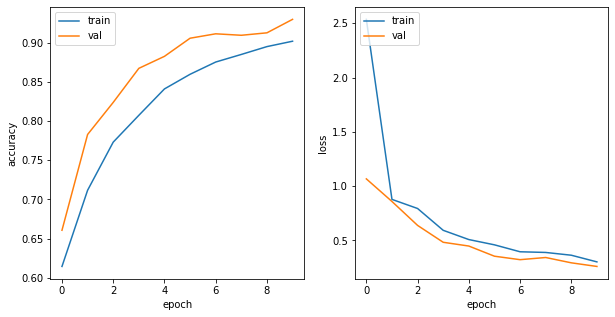

In [60]:
plot_history(resnet152V2_history)

In [61]:
resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet152V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 3200 images belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9121875
Global F2 Score: 0.9121875


,Precision,Recall,F-Score,Support
ForestLand,0.823691,0.996667,0.901961,600.0
HerbaceousVegetationLand,0.949550,0.878333,0.912554,600.0
HighYieldCropsLand,0.975342,0.890000,0.930719,400.0
PermanentCrop,0.886680,0.892000,0.889332,500.0
UnSuitablefarmLand,0.915521,0.932000,0.923687,500.0
VegetationCrop,0.970480,0.876667,0.921191,600.0


In [62]:
# Save the model and the weights
resnet152V2_model.save('../working/ResNet152V2_eurosat.h5')

In [63]:
# VGG16
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [64]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 10

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [65]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=5,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


200/200 [==============================] - 23s 109ms/step - loss: 8.1405 - categorical_accuracy: 0.5319 - val_loss: 0.5649 - val_categorical_accuracy: 0.8275

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82750, saving model to ../working/model.weights.best.hdf5
Epoch 2/5
200/200 [==============================] - 20s 101ms/step - loss: 0.8134 - categorical_accuracy: 0.7054 - val_loss: 0.5455 - val_categorical_accuracy: 0.8109

Epoch 00002: val_categorical_accuracy did not improve from 0.82750
Epoch 3/5
200/200 [==============================] - 21s 104ms/step - loss: 0.7588 - categorical_accuracy: 0.7359 - val_loss: 0.4775 - val_categorical_accuracy: 0.8491

Epoch 00003: val_categorical_accuracy improved from 0.82750 to 0.84906, saving model to ../working/model.weights.best.hdf5
Epoch 4/5
200/200 [==============================] - 21s 105ms/step - loss: 0.7671 - categorical_accuracy: 0.7296 - val_loss: 0.4901 - val_categorical_accuracy: 0.8431

Epoch 00004: val_categor

In [66]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10
200/200 [==============================] - 25s 117ms/step - loss: 1.2190 - categorical_accuracy: 0.5323 - val_loss: 0.5224 - val_categorical_accuracy: 0.8188

Epoch 00001: val_categorical_accuracy did not improve from 0.84906
Epoch 2/10
200/200 [==============================] - 23s 116ms/step - loss: 0.5825 - categorical_accuracy: 0.8080 - val_loss: 0.2586 - val_categorical_accuracy: 0.9209

Epoch 00002: val_categorical_accuracy improved from 0.84906 to 0.92094, saving model to ../working/model.weights.best.hdf5
Epoch 3/10
200/200 [==============================] - 23s 116ms/step - loss: 0.3492 - categorical_accuracy: 0.8928 - val_loss: 0.2317 - val_categorical_accuracy: 0.9322

Epoch 00003: val_categorical_accuracy improved from 0.92094 to 0.93219, saving model to ../working/model.weights.best.hdf5
Epoch 4/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2977 - categorical_accuracy: 0.9072 - val_loss: 0.1575 - val_categorical_accuracy: 0.9500

Epoch 0

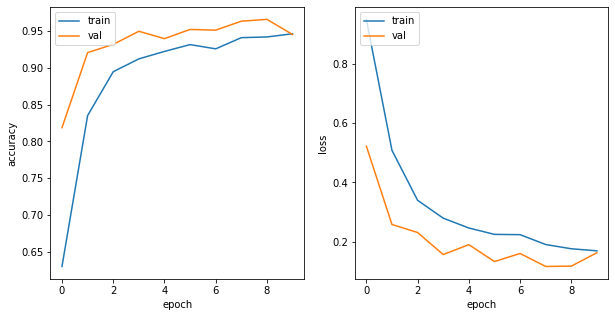

In [67]:
plot_history(vgg16_history)

In [68]:
vgg16_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 3200 images belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9634375
Global F2 Score: 0.9634374999999998


,Precision,Recall,F-Score,Support
ForestLand,0.958266,0.995000,0.976288,600.0
HerbaceousVegetationLand,0.968121,0.961667,0.964883,600.0
HighYieldCropsLand,0.931116,0.980000,0.954933,400.0
PermanentCrop,0.931907,0.958000,0.944773,500.0
UnSuitablefarmLand,0.989817,0.972000,0.980827,500.0
VegetationCrop,0.994595,0.920000,0.955844,600.0


In [69]:
# Save the model and the weights
vgg16_model.save('../working/vgg16_eurosat.h5')

In [70]:
# VGG 19
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg19_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [71]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 10

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [72]:
train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
200/200 [==============================] - 22s 108ms/step - loss: 9.5027 - categorical_accuracy: 0.4765 - val_loss: 0.8593 - val_categorical_accuracy: 0.6841

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68406, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
200/200 [==============================] - 21s 104ms/step - loss: 0.9553 - categorical_accuracy: 0.6364 - val_loss: 0.6571 - val_categorical_accuracy: 0.7550

Epoch 00002: val_categorical_accuracy improved from 0.68406 to 0.75500, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
200/200 [==============================] - 21s 105ms/step - loss: 0.9100 - categorical_accuracy: 0.6666 - val_loss: 0.6298 - val_categorical_accuracy: 0.7928

Epoch 00003: val_categorical_accuracy improved from 0.75500 to 0.79281, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
200/200 [==============================] - 21s 105ms/step - loss: 0.9376 - categorical_accuracy: 0.6597 - val_los

In [73]:
# re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg19_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10
200/200 [==============================] - 26s 121ms/step - loss: 2.4803 - categorical_accuracy: 0.2742 - val_loss: 1.3711 - val_categorical_accuracy: 0.4550

Epoch 00001: val_categorical_accuracy did not improve from 0.81594
Epoch 2/10
200/200 [==============================] - 24s 120ms/step - loss: 1.2482 - categorical_accuracy: 0.4991 - val_loss: 0.8470 - val_categorical_accuracy: 0.6634

Epoch 00002: val_categorical_accuracy did not improve from 0.81594
Epoch 3/10
200/200 [==============================] - 23s 117ms/step - loss: 0.9236 - categorical_accuracy: 0.6473 - val_loss: 0.7660 - val_categorical_accuracy: 0.7441

Epoch 00003: val_categorical_accuracy did not improve from 0.81594
Epoch 4/10
200/200 [==============================] - 24s 121ms/step - loss: 0.7338 - categorical_accuracy: 0.7274 - val_loss: 0.5384 - val_categorical_accuracy: 0.8097

Epoch 00004: val_categorical_accuracy did not improve from 0.81594
Epoch 5/10
200/200 [==============================] 

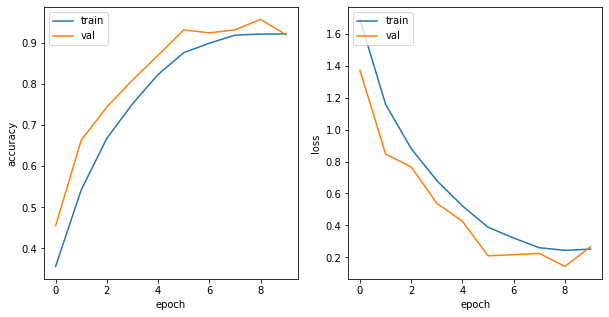

In [74]:
plot_history(vgg19_history)

In [75]:
vgg19_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 3200 images belonging to 6 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9484375
Global F2 Score: 0.9484375


,Precision,Recall,F-Score,Support
ForestLand,0.896084,0.991667,0.941456,600.0
HerbaceousVegetationLand,0.953688,0.926667,0.939983,600.0
HighYieldCropsLand,0.978082,0.892500,0.933333,400.0
PermanentCrop,0.934694,0.916000,0.925253,500.0
UnSuitablefarmLand,0.976285,0.988000,0.982107,500.0
VegetationCrop,0.971284,0.958333,0.964765,600.0


In [76]:
# Save the model and the weights
vgg19_model.save('../working/vgg19_eurosat.h5')

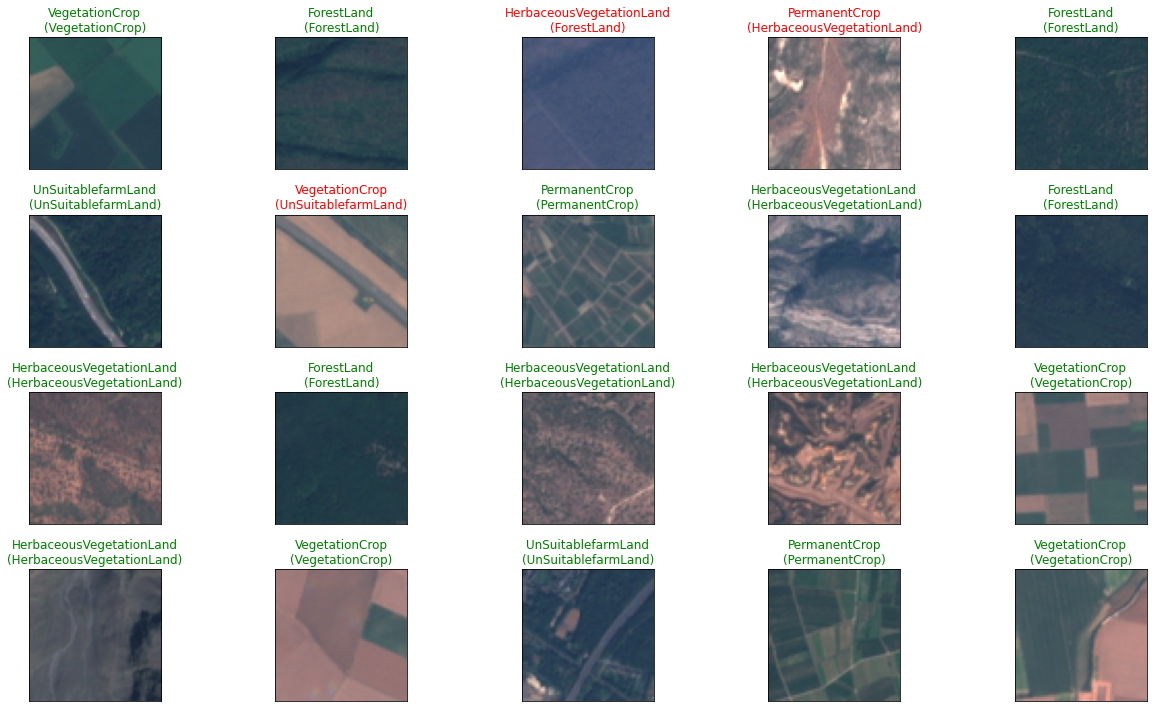

In [77]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)